In [25]:
import numpy                as np
from os                     import listdir
import matplotlib.pyplot    as plt
import matplotlib           as mpl
import matplotlib.lines     as mlines
from natsort                import natsorted
import os
import json

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/STER/silkem/ChemTorch/')
import modclass
import src.rates as rate

def makeOutputDir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path

## get species
specs, parnt, convs = rate.read_specs_file('C', 16)

specs_dict = dict()
idx_specs  = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i
    idx_specs[i] = specs[i]

### ChemTorch - scipy ODE solver

In [26]:

here = os.path.abspath(os.getcwd())
outpath = '/STER/silkem/ChemTorch/out/'
## scipy implementation
# dirname = 'bm_C_Mdot1e-6_v15'
dirname = 'bm_C_Mdot1e-8_v2-5'

## load 0D model dirs
dirs = listdir(outpath+dirname+'/')
dirs.remove('meta.json')
dirs = natsorted(dirs)

## load meta file
with open(outpath+dirname+'/meta.json', 'r') as f:
    meta=f.read()

meta = json.loads(meta)

In [27]:
meta

{'1Dmodel': '/STER/silkem/CSEchem/20210518_gridC_Mdot1e-8_v2-5_T_epsmodel_2022-12-24h23-19-06',
 'Mdot': 1e-08,
 'v': 250000.0,
 'eps': 0.6,
 'T_star': 2500.0,
 'solvertype': 'scipy'}

In [28]:
abs = []
p = []
dt = []
solver_time = []
overhead = []

for i in range(len(dirs)):
    chem = modclass.ChemTorchMod(dirname, dirs[i])
    abs.append(chem.n.T[-1])
    dt.append(chem.tstep[-1])
    p.append(chem.p)
    solver_time.append(chem.tictoc[0])
    overhead.append(chem.tictoc[1])

abs = np.array(abs)
p = np.array(p)
dt = np.array(dt)
solver_time = np.array(solver_time)
overhead = np.array(overhead)

In [21]:
dt

array([5.480e+07, 6.160e+07, 6.880e+07, 7.720e+07, 8.680e+07, 9.760e+07,
       1.092e+08, 1.224e+08, 1.376e+08, 1.544e+08, 1.732e+08, 1.944e+08,
       2.180e+08, 2.444e+08, 2.748e+08, 3.076e+08, 3.456e+08, 3.880e+08,
       4.348e+08, 4.880e+08, 5.480e+08, 6.160e+08, 6.880e+08, 7.720e+08,
       8.680e+08, 9.760e+08, 1.092e+09, 1.224e+09, 1.376e+09, 1.544e+09,
       1.732e+09, 1.944e+09, 2.180e+09, 2.444e+09, 2.748e+09, 3.076e+09,
       3.456e+09, 3.880e+09, 4.348e+09, 4.880e+09, 5.480e+09, 6.160e+09,
       6.880e+09, 7.720e+09, 8.680e+09, 9.760e+09, 1.092e+10, 1.224e+10,
       1.376e+10, 1.544e+10, 1.732e+10, 1.944e+10, 2.180e+10, 2.444e+10,
       2.748e+10, 3.076e+10, 3.456e+10, 3.880e+10, 4.348e+10, 4.880e+10,
       5.480e+10, 6.160e+10, 6.880e+10, 7.720e+10, 8.680e+10, 9.760e+10,
       1.092e+11, 1.224e+11, 1.376e+11, 1.544e+11, 1.732e+11, 1.944e+11,
       2.180e+11, 2.444e+11, 2.748e+11, 3.076e+11, 3.456e+11, 3.880e+11,
       4.348e+11])

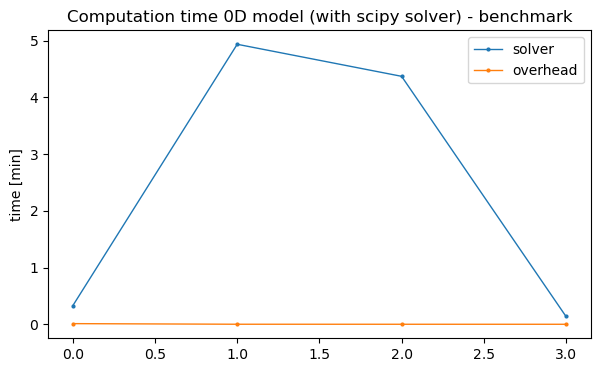

In [29]:
fig, ax1 = plt.subplots(figsize = (7,4)) 
ax1.set_title('Computation time 0D model (with scipy solver) - benchmark')

ax1.plot(solver_time /60., '-o',ms = 2,lw = 1, label = 'solver')
ax1.plot(overhead /60.  , '-o',ms = 2,lw = 1, label = 'overhead')

ax1.set_ylabel('time [min]')

plt.legend()

makeOutputDir(here+'/'+dirname)
plt.savefig(here+'/'+dirname+'/computation_time')

plt.show()

### 1D CSE model

In [33]:
CSEmodel = modclass.CSEmod(loc = 'STER', dir = meta['1Dmodel'][20:-26], modelname = meta['1Dmodel'][-25:])

FileNotFoundError: [Errno 2] No such file or directory: '/STER/silkem/CSEchem//20210518_gridC_Mdot1e-8_v2-5_T_ep-model_2022-12-24h23-19-06/inputChemistry_model_2022-12-24h23-19-06.txt'

In [13]:
CSEmodel.v/100000.0, CSEmodel.Mdot

(2.5, 1e-08)

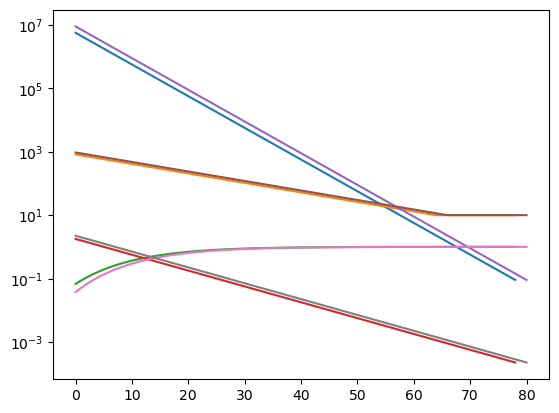

In [22]:
p = np.array(p)

plt.plot(p)

plt.plot(CSEmodel.dens)
plt.plot(CSEmodel.temp)
plt.plot(CSEmodel.delta)
plt.plot(CSEmodel.Av)

plt.yscale('log')


plt.show()

In [34]:
p

array([[9.016e+06, 9.518e+02, 3.752e-02, 2.242e+00],
       [7.162e+06, 8.883e+02, 5.107e-02, 1.998e+00],
       [5.689e+06, 8.290e+02, 6.754e-02, 1.781e+00],
       [4.519e+06, 7.737e+02, 8.700e-02, 1.587e+00]])

### ChemTorch - torch ode solver

In [24]:
## torchode implementation
dirname_torch = 'bm_torch'
dirs_torch = listdir(outpath+dirname_torch+'/')
dirs_torch.remove('meta.json')
dirs_torch = natsorted(dirs_torch)

In [25]:
abs_t = []
p_t = []
dt_t = []
solver_time_t = []
overhead_t = []

for i in range(len(dirs_torch)):
    chem = modclass.ChemTorchMod(dirname_torch, dirs_torch[i])
    abs_t.append(chem.n.T[-1])
    dt_t.append(chem.tstep[-1])
    p_t.append(chem.p)
    solver_time_t.append(chem.tictoc[0])
    overhead_t.append(chem.tictoc[1])

abs_t = np.array(abs_t)
p_t = np.array(p_t)
dt_t = np.array(dt_t)
solver_time_t = np.array(solver_time_t)
overhead_t = np.array(overhead_t)

In [65]:
abs_t[10]

array([ 4.94065646e-324,  0.00000000e+000,  0.00000000e+000,
        6.30385077e-316,  9.38724727e-323,  6.36598737e-314,
       -4.94065646e-324,  2.12199579e-314,  0.00000000e+000,
        0.00000000e+000,  6.90646962e-310,  6.47228407e-316,
        0.00000000e+000,  2.12199377e-314,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        6.48403374e-316,  0.00000000e+000,              nan,
        0.00000000e+000,              nan,  6.48403908e-316,
        6.48403888e-316,  6.48404046e-316,  2.12199579e-314,
                    nan,  0.00000000e+000,  6.48404204e-316,
        4.24399158e-314,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,              nan,  6.48411200e-316,
        7.41098469e-323,  6.36598737e-314,  4.94065646e-324,
        2.12199579e-314,  0.00000000e+000,  0.00000000e+000,
        2.03159794e-320,  5.13828272e-321,              nan,
        0.00000000e+000,              nan,              nan,
                    nan,

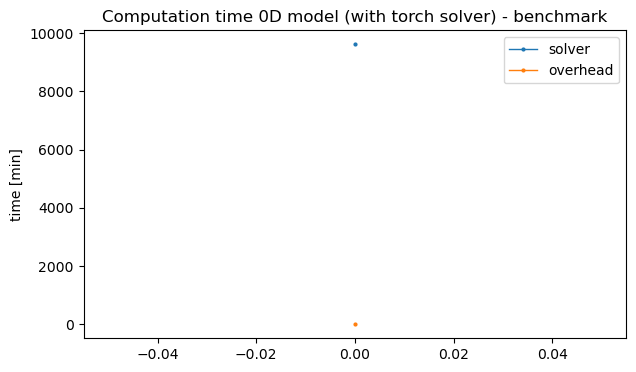

In [26]:
fig, ax1 = plt.subplots(figsize = (7,4)) 
ax1.set_title('Computation time 0D model (with torch solver) - benchmark')

ax1.plot(solver_time_t * 1./60., '-o',ms = 2,lw = 1, label = 'solver')
ax1.plot(overhead_t * 1./60.  , '-o',ms = 2,lw = 1, label = 'overhead')

ax1.set_ylabel('time [min]')

plt.legend()
plt.show()

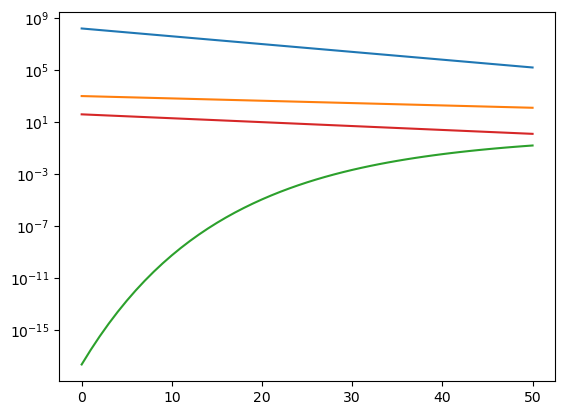

In [58]:

plt.plot(p_t)

plt.yscale('log')

plt.show()

## Plotting the benchmark

In [17]:
def get_time(dt):
    t = np.zeros(len(dt))
    t[0] = CSEmodel.time[0]
    for i in range(1,len(dt)):
        t[i] = (dt[i]+t[i-1])
        
    return np.array(t)

In [18]:
timearr = get_time(dt)

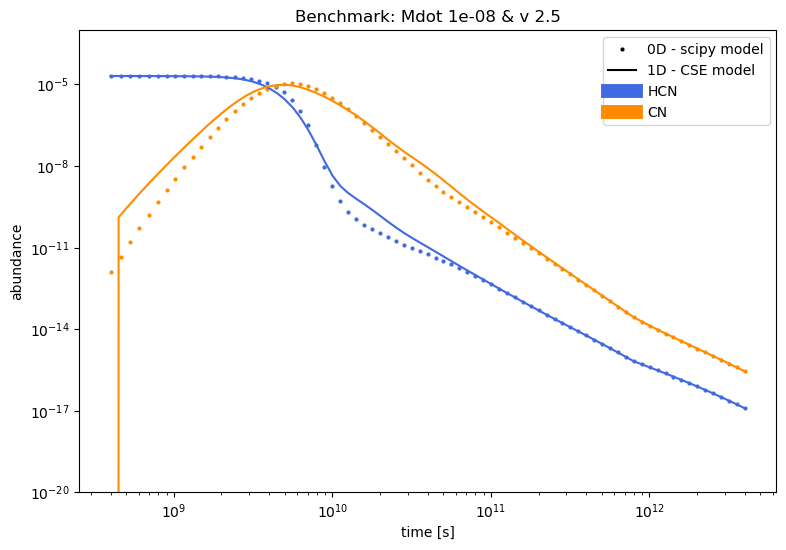

In [19]:
fig, ax1 = plt.subplots(figsize = (9,6)) 

par = 'HCN'
dau = 'CN'

i = specs_dict[par]
j = specs_dict[dau]

c1 = 'royalblue'
c2 = 'darkorange'

lw = 10
ms = 2

## legend setup
l_par = mlines.Line2D([],[], color = c1, ls = '-'    , label=par,lw = lw, alpha = 1)
l_dau = mlines.Line2D([],[], color = c2, ls = '-'    , label=dau,lw = lw, alpha = 1)
l_1D  = mlines.Line2D([],[], color = 'k', ls = '-'   , label='1D - CSE model')
l_0D  = mlines.Line2D([],[], color = 'k', ls = 'none', label='0D - scipy model', marker = 'o' ,  markersize = ms)
handles = [l_0D, l_1D, l_par, l_dau]


ax1.set_title('Benchmark: Mdot '+str(meta['Mdot'])+' & v '+str(meta['v']))

ax1.plot(timearr,abs.T[i], 'o', ms=ms, label = '0Dscipy, water', c= 'royalblue')
ax1.plot(timearr,abs.T[j], 'o', ms=ms, label = '0Dscipy, OH', c= 'darkorange')

# ax1.plot(abs_t[i], '-.', label = '0Dtorch, water')
# ax1.plot(abs_t[j], '-.', label = '0Dtorch, OH')

ax1.plot(CSEmodel.time,CSEmodel.n.T[i], '-', label = '1D, water', c= 'royalblue')
ax1.plot(CSEmodel.time,CSEmodel.n.T[j], '-', label = '1D, OH' ,c= 'darkorange')


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-20,1e-3])

ax1.set_xlabel('time [s]')
ax1.set_ylabel('abundance')

ax1.legend(handles=handles)

makeOutputDir(here+'/'+dirname)
plt.savefig(here+'/'+dirname+'/benchmark_'+par+'_'+dau)

plt.show()